## 1. Transformer
---

大名鼎鼎，论文地址：[Transformer](https://arxiv.org/pdf/1706.03762)

实现了深度循环神经网络并行计算

In [3]:
from IPython.display import Image, display
url = 'https://theaisummer.com/static/6122618d7e1466853e88473ba375cdc7/40ffe/transformer.png'
display(Image(url=url, width=600))

## 2. 数学过程

### 2.1 编码

分两步：

**1. 词嵌入（Input & Embedding）**

字典大小 vocab_size × embed_dim

词大小 1 × embed_dim
    
句子大小 seq_len × embed_dim

批量句子大小 batch_size × seq_len × embed_dim

**2. 位置编码（Positional Encoding）**

由于 Transformer 的自注意力机制本身不具备对输入顺序的感知能力，位置编码在 Transformer 架构中引入序列位置信息。

为每个位置生成唯一的编码向量，直接加到词嵌入上。

位置编码数学公式，根据位置p、维度i、词嵌入维度d, 偶数维和奇数维交替使用正弦和余弦。

正弦：$PE_{(p, i, d)}=\sin(\frac{p}{10000^{2i/d}})$

余弦：$PE_{(p, i, d)}=\cos(\frac{p}{10000^{2i/d}})$

矩阵大小 seq_len × embed_dim

批量大小 batch_size × seq_len × embed_dim

**3. 编码结果**

X = E + P

批量维度 batch_size × seq_len × embed_dim

**4. 位置编码的讨论**

上面采用正弦和余弦公式是原始论文中所采用的方式。  
存在的主要问题是，位置编码的公式是固定的，不可学习，而且在最后采用将位置编码直接加到词向量上，污染了信息。  
随着研究的深入，旋转位置嵌入（Rotary Positional Embedding, RoPE）的模式得到很大关注。这里有篇论文。[RoPE](https://arxiv.org/pdf/2410.06205)  
原始的位置编码，从开始可以看作是一种二进制的方波，但因为跳跃变化，采用了类似正弦余弦波的编码方式。  
下面总结一下个人看法：  
（1）词嵌入是没有位置关系的，也没有多重语义，但的确编码了大部分语言符号的意思的差异。我将之成为全局性语义向量（Global Semantic Vector）。之所以这么称呼的原因是因为，词嵌入更多的表达的是一种数据转换，将语言符号转换为数字。全局性语义向量，一方面是从更加自然性的语言角度理解，另一方面表示词汇在语义空间上的向量表达。  
（2）词汇之间的位置关系和语义关联，是和使用词汇的场景是高度关联的。如果我们将之称为局部语义空间，那么位置编码可以看作是是从全局性语义向量向局部语义向量（Local Semantic Vector）做的一个映射，映射后的局部语义向量看作是上下文中词汇语义的真实表达。  
（3）当然在操作上，我们希望这个映射是线性的。而且，如果上下文中的某些位置关联紧密，那么它们之间的局部语义向量之间应该有更高的余弦相似度。于是，位置p的向量V(p)可以经由某个矩阵变换M得到p+k位置的相似向量V(p+k)。可参见[RoFormer论文](https://arxiv.org/pdf/2104.09864)  
（4）最终结果是通过矩阵乘法的形式（实际上采用的是克式积），实现了由全局性语义空间向局部语义空间的映射。避免了加法带来的语义污染，并且具有了科学系的特征。  
（5）编码可以看作两步：词汇符号→全局语义向量→局部语义向量。

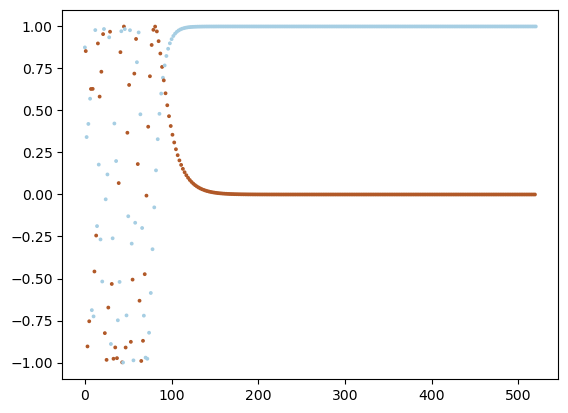

In [4]:
# 经典PE的数值分布
import numpy as np
import matplotlib.pyplot as plt

def pe(seq_len, embed_dim):
    L = []
    for i in range(seq_len):
        if i%2==0:
            L.append(round(np.cos(seq_len/(10000**(2*i/embed_dim))),4))
        else:
            L.append(round(np.sin(seq_len/(10000**(2*i/embed_dim))),4))
    return L
L = pe(521, 256)
C = [x % 2 for x in range(len(L)) ]
plt.scatter(x=np.arange(len(L)), y=L, s=3, c=C, cmap='Paired')

### 2.2 注意力机制

注意力机制有很多变体。  
这里按照逐层深入的方式，拆解为：单头注意力、多头注意力、掩码多头注意力、交叉多头注意力。  
后续优化变体多查询注意力(MQA)，分组查询注意力(GQA)，多潜头注意力(MLA)。  

厘清维度+理解作用是关键。 
先定义一些超参数，方便后面理解  
vocab_size：词表大小（一般为50000左右）。字母：V  
embed_dim：词向量维度。字母 C  
batch_size：批量大小。字母 B  
seq_len：上下文长度。字母 T  
num_heads：注意力头的数量。字母 n  
single_head_dim：单个注意力头的维数。字母 s  
multi_head_dim = single_head_dim × num_heads：多头注意力维数，一般等于embed_dim。字母 H  

Attention最著名的公式：$$\mathbf{Attention}(Q, K, V)=\mathbf{softmax}(\frac{QK^T}{\sqrt{d_k}})V $$

里面涉及三个重要的向量Q, K, V, 分别代表查询（Query）、键（Key）和值（Value）。  
Transformer左边是编码器，右边是解码器。编码器最终输出K, V用于右边的解码器，而解码器用自身的Q。  
所以查询的意思是容易理解的。  
再看公式的最后，是关于V的某个线性组合，所以值的意思也清楚。
键的意思是作为参考而言的。

-----

下面是**单头注意力**的维度变化情况：  
1. 输入X的维度是(B, T, C)，复制三份。
2. 与查询矩阵$W_Q$作用，得到Q。即X经过$W_Q$线性变换得到Q。$W_Q$的维度是(B, C, H)，Q的维度是(B, T, H)
>如是线性变换，按照矩阵乘法，$W_Q$应该在X的左边，即$XW_Q$，但很多论文和研究报告，都把X写在左边，这主要是因为在变换之后，X的C维度会消失，写在左边符合矩阵乘法的直觉，但在变换的视角下又是别扭的，这归功于pytorch在维度处理上的优秀设计。

3. 同样的有键矩阵$W_K$，作用在X上。$W_K$的维度是(B, C, H)，K的维度是(B, T, H)
4. 进行点积+缩放操作，即 $\frac{QK^T}{\sqrt{d_k}}$，结果维度是(B, T, T)
>上述操作将输入X经过线性变化从原来的(B, T, C)变换到(B, T, H)空间进行表示。
>点积操作是为了比较一个序列中，各位置上元素的距离，可以用余弦相似度来理解
>缩放是出于数值稳定性的考虑，其中$d_k$是每个头的维度，但单头注意力中等于H

5. softmax使其称为一个概率分布，注意力权重矩阵，torch中是每一行，矩阵乘法中是每一列
6. 有值矩阵$W_V$，作用在X上。$W_V$的维度是(B, C, H)，V的维度是(B, T, H)
7. 将权重矩阵和V相乘，得到结果，维度是(B, T, H)，与输入维度一致。注：在多元线性回归中，我们一般是将权重写在右侧的，如$||Y-Xw-b||^2$，其中$w$是权重
8. 残差连接
9. 层归一化，沿最后一维归一化。
10. 再接前馈神经网络或混合专家模型。

---

**多头注意力**，在计算出Q,K,V之后，进行分割。
维度变化：  
$X:(B, T, C)$  
$Q, K, V:(B, T, H)$  
分割后：$Q^i, K^i, V^i:(B, n, T, s), \ \  H=n×s$  
点击+缩放：$(B, n, T, T)$  
softmax：$(B, n, T, T)$  
与$V^i$相乘：$(B, n, T, s)$  
拼接输出：$(B, T, H)$，与输入维度一致  
后续无变化。

多头注意力，相比单头注意力，通过多个不同的子空间用于关于不同结构上的特征。

参数和单头注意力一样多，但计算上可以并行，提高计算效率。

---

**掩码自注意力**的另一个名称是因果自注意力。

掩码多头注意力，维度变化与多头注意力是一样的。

两者的主要区别是在softmax这个步骤上。掩码多头注意力会在这个分数矩阵上加上一个掩码矩阵，通常是下三角矩阵，将未来位置的得分设置为-inf，使得softmax后这些位置的权重接近0。

In [22]:
import torch
import torch.nn.functional as F

mask = torch.triu(torch.ones(5, 5), diagonal=1).bool()
scores = torch.randn(5, 5)
print(scores)
scores = scores.masked_fill(mask, -1e9)
print(scores)
F.softmax(scores, dim=-1)

tensor([[ 1.0182,  1.1535, -1.7100, -0.2435,  1.1991],
        [-1.1976,  0.1862,  0.9975, -0.6647,  0.8301],
        [ 1.0701,  1.3209, -0.5289,  0.0137, -0.2921],
        [ 0.9137,  0.3797, -0.1829, -2.7691,  0.4461],
        [ 2.1975,  0.3053, -0.7171, -1.1248,  0.7243]])
tensor([[ 1.0182e+00, -1.0000e+09, -1.0000e+09, -1.0000e+09, -1.0000e+09],
        [-1.1976e+00,  1.8616e-01, -1.0000e+09, -1.0000e+09, -1.0000e+09],
        [ 1.0701e+00,  1.3209e+00, -5.2889e-01, -1.0000e+09, -1.0000e+09],
        [ 9.1374e-01,  3.7970e-01, -1.8290e-01, -2.7691e+00, -1.0000e+09],
        [ 2.1975e+00,  3.0532e-01, -7.1708e-01, -1.1248e+00,  7.2425e-01]])


tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2004, 0.7996, 0.0000, 0.0000, 0.0000],
        [0.4021, 0.5167, 0.0813, 0.0000, 0.0000],
        [0.5140, 0.3013, 0.1717, 0.0129, 0.0000],
        [0.6802, 0.1025, 0.0369, 0.0245, 0.1559]])

**交叉多头注意力**

一般不需要掩码

维度变化和多头注意力一样，只不过K,V用的是编码器输出，Q是解码输入。

**KV Cache**: 增量计算。这得益于矩阵乘法分片裁切的效果。  
**多查询注意力（Multi-Query Attention, MQA）**：让所有头共享K，V值，只切割Q。具体做法是，在$K=XW_K$这步计算时，直接将K降到(B, C, s)大小，在点积缩放时进行广播。  
**分组查询注意力 (Grouped Query Attention, GQA)**：引入超参数组数，不要所有头都一样了，而是在头里进行分组，组内用一样的K,V  
**MLA（Multi-Head Local Attention, MLA）**: DeepSeek模型中使用，目的是为了减少内存的占用，有点像奇异值分解。 **待研究** 

### 2.3 前馈神经网络(FeedforwardNeural Network，FFN)

前馈神经网络，又称为全连接层（Fully Connected Layer）或密集层（Dense Layer）。
这里讲的很好：[FFN](https://mp.weixin.qq.com/s?__biz=MzUzOTgwNDMzOQ==&mid=2247503288&idx=1&sn=ee4b2bc1b396a1e82725998911ded45d&chksm=fac05a64cdb7d372181dd1017b99a13d444bfc0c257002f8018560af83fde1bbf69f182c5f37&scene=178&cur_album_id=3876802058308993025#rd)

数学表达上是简单的：  

（1）升维：$X^{B\times T\times 4C} = X^{B\times T\times C}W_1^{B\times C\times 4C} + b_1^{B\times T\times 4C}$  
（2）激活：$X^{B\times T\times 4C} = \phi(X^{B\times T\times 4C})$  
（3）降维：$X^{B\times T\times C} = X^{B\times T\times 4C}W_2^{B\times 4C\times C} + b_2^{B\times T\times C}$

输出和输入维度一样。激活层必不可少。因为attention模块最后的结果是V的线性组合。并没有引入非线性。

4C的原因是信息丢失补偿。

### 2.4 混合专家模型 (Mixed Expert Models，MoEs)

核心构件包括两部分：专家网络，如FNN；门控网络  
输出是TopK个专家的加权，一般K取很小的值，如1或2。 $output = \sum_{i=1}^N G(x)_i\times E_i(x)$   
门控网络，$G(x)=softmax(TopK(W_gx+b_g, k))$  
专家网络，$FFN(x)$    
负载均衡约束：$L_{balance} = \lambda\cdot\sum_{i=1}^Nf_i\cdot P_i$
总损失：$L_{total} = L_{task} + L_{balance} $    

优点：在远低于稠密模型的计算成本下进行高效预训练。

缺点：微调阶段容易泛化能力不足，导致过拟合；虽然 MoE 只激活部分参数进行推理，速度快于同等规模的稠密模型，但所有参数仍需加载到内存，导致较高的 VRAM 需求

---

## 3. 文本生成

模拟训练

### 3.1 导入必要的包

In [1]:
import torch
import torch.nn as nn
import math
import time
import psutil

from datasets import load_dataset
from transformers import AutoTokenizer
from torch.utils.data import DataLoader
from torch.amp import autocast, GradScaler
import torch.optim as optim

### 3.2 设定超参数

In [2]:
batch_size= 64
seq_len = 128
embed_dim = 64
num_heads = 4
num_encoder_layers = 2
dropout= 0.2
lr= 1e-3
epochs= 20
device= 'cuda' if torch.cuda.is_available() else 'cpu'

### 3.3 处理数据

In [3]:
dataset = load_dataset("wikitext", "wikitext-2-raw-v1", cache_dir='./cache')
tokenizer = AutoTokenizer.from_pretrained("distilgpt2", cache_dir="./cache")
tokenizer.pad_token = tokenizer.eos_token
vocab_size = len(tokenizer)
vocab_size

50257

In [4]:
print(dataset)

DatasetDict({
    test: Dataset({
        features: ['text'],
        num_rows: 4358
    })
    train: Dataset({
        features: ['text'],
        num_rows: 36718
    })
    validation: Dataset({
        features: ['text'],
        num_rows: 3760
    })
})


In [5]:
tokenizer.model_max_length = seq_len
tokenizer.model_input_names = ["input_ids"]

In [6]:
# 示例
text = "The Hub has support for dozens of libraries in the Open Source ecosystem. \
Thanks to the huggingface_hub Python library, it’s easy to enable sharing your models on the Hub. \
The Hub supports many libraries, and we’re working on expanding this support. \
We’re happy to welcome to the Hub a set of Open Source libraries that are pushing Machine Learning forward."

# 分词
tokens = tokenizer.tokenize(text)
print("Tokens:", len(tokens), tokens)

Tokens: 78 ['The', 'ĠHub', 'Ġhas', 'Ġsupport', 'Ġfor', 'Ġdozens', 'Ġof', 'Ġlibraries', 'Ġin', 'Ġthe', 'ĠOpen', 'ĠSource', 'Ġecosystem', '.', 'ĠThanks', 'Ġto', 'Ġthe', 'Ġhugging', 'face', '_', 'hub', 'ĠPython', 'Ġlibrary', ',', 'Ġit', 'âĢ', 'Ļ', 's', 'Ġeasy', 'Ġto', 'Ġenable', 'Ġsharing', 'Ġyour', 'Ġmodels', 'Ġon', 'Ġthe', 'ĠHub', '.', 'ĠThe', 'ĠHub', 'Ġsupports', 'Ġmany', 'Ġlibraries', ',', 'Ġand', 'Ġwe', 'âĢ', 'Ļ', 're', 'Ġworking', 'Ġon', 'Ġexpanding', 'Ġthis', 'Ġsupport', '.', 'ĠWe', 'âĢ', 'Ļ', 're', 'Ġhappy', 'Ġto', 'Ġwelcome', 'Ġto', 'Ġthe', 'ĠHub', 'Ġa', 'Ġset', 'Ġof', 'ĠOpen', 'ĠSource', 'Ġlibraries', 'Ġthat', 'Ġare', 'Ġpushing', 'ĠMachine', 'ĠLearning', 'Ġforward', '.']


In [7]:
def tokenize(example):
    return tokenizer(example["text"], truncation=True, max_length=seq_len, padding="max_length")

In [8]:
encoding = tokenizer(text, padding=True, truncation=True, max_length=20, return_tensors="pt")
print(encoding)

{'input_ids': tensor([[  464, 14699,   468,  1104,   329,  9264,   286, 12782,   287,   262,
          4946,  8090, 13187,    13,  6930,   284,   262, 46292,  2550,    62]])}


In [9]:
tokenized = dataset.map(tokenize, batched=True, remove_columns=["text"])
tokenized.set_format(type='torch', columns=["input_ids"])

In [10]:
train_loader = DataLoader(tokenized["train"], batch_size=batch_size, shuffle=True)
val_loader = DataLoader(tokenized["validation"], batch_size=batch_size, shuffle=False)

### 3.4 定义网络

In [11]:
# 旋转位置编码，对每个二维子空间进行旋转
def apply_rope(x):
    B, T, H, D = x.shape #输入，batch_size, seq_len, num_heads, head_dim
    assert D % 2 == 0
    half = D // 2
    freqs = 1.0 / (10000 ** (torch.arange(0, half, device=x.device).float() / half)) # embed_dim/2 数组
    pos = torch.arange(0, T, device=x.device).float()
    angles = torch.einsum("i,j->ij", pos, freqs) # 外积，T, half，爱因斯坦求和约定
    sin, cos = angles.sin(), angles.cos()
    sin = sin.unsqueeze(0).unsqueeze(2) # 添加维度占位
    cos = cos.unsqueeze(0).unsqueeze(2)
    x1, x2 = x[..., :half], x[..., half:] # 按最后一个维度切片
    return torch.cat([x1 * cos - x2 * sin, x1 * sin + x2 * cos], dim=-1) # 利用广播机制

In [12]:
class MultiHeadAttention(nn.Module):
    def __init__(self, embed_dim, num_heads):
        super().__init__()
        assert embed_dim % num_heads == 0
        self.head_dim = embed_dim // num_heads
        self.num_heads = num_heads
        self.wq = nn.Linear(embed_dim, embed_dim)
        self.wk = nn.Linear(embed_dim, embed_dim)
        self.wv = nn.Linear(embed_dim, embed_dim)
        self.fc = nn.Linear(embed_dim, embed_dim)

    def forward(self, x, attention_mask=None):
        B, T, D = x.shape # D: embed_dim
        q = self.wq(x).view(B, T, self.num_heads, self.head_dim).transpose(1, 2) # B, num_heads, T, head_dim
        k = self.wk(x).view(B, T, self.num_heads, self.head_dim).transpose(1, 2)
        v = self.wv(x).view(B, T, self.num_heads, self.head_dim).transpose(1, 2)        

        q = apply_rope(q.transpose(1, 2)).transpose(1, 2) # 先和apply_rope对齐，B, T, num_heads, head_dim ---> B, num_heads, T, head_dim
        k = apply_rope(k.transpose(1, 2)).transpose(1, 2)
        attention_scores = (q @ k.transpose(-2, -1)) / math.sqrt(self.head_dim) # B, num_heads, T, T
        if attention_mask is not None: # attention mask的形状 T, T 会被广播到 B, num_heads, T, T
            attention_scores = attention_scores.masked_fill(attention_mask, float('-inf'))
        attention_weights  = torch.softmax(attention_scores, dim=-1) # B, num_heads, T, T

        attention_output = attention_weights @ v  #  B, num_heads, T, head_dim
        attention_output = attention_output.transpose(1, 2).contiguous().view(B, T, D)
        return self.fc(attention_output) # B, T, D

In [13]:
class TransformerBlock(nn.Module):
    def __init__(self, embed_dim, num_heads, dropout):
        super().__init__()
        self.attention = MultiHeadAttention(embed_dim, num_heads)
        self.ln1 = nn.LayerNorm(embed_dim)
        self.ff = nn.Sequential(
            nn.Linear(embed_dim, embed_dim*4),
            nn.GELU(),
            nn.Linear(embed_dim*4, embed_dim),
            nn.Dropout(dropout)
        )
        self.ln2 = nn.LayerNorm(embed_dim)
    
    def forward(self, x, attention_mask=None):
        attention_out = self.attention(x, attention_mask=attention_mask) # 多头自注意力输出
        x = self.ln1(x+attention_out) # 残差连接
        ff_out = self.ff(x) # feedforward 输出
        return self.ln2(x + ff_out) # 归一化

In [14]:
class TransformerLM(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_heads, num_layers, dropout):
        super().__init__()
        self.token_emb = nn.Embedding(vocab_size, embed_dim)
        self.blocks = nn.ModuleList([TransformerBlock(embed_dim, num_heads, dropout) for _ in range(num_layers)]) # 列表推导式，堆叠Transformer块
        self.ln = nn.LayerNorm(embed_dim)
        self.head = nn.Linear(embed_dim, vocab_size)

    def forward(self, x): # 输入X  batch_size, seq_len
        B, T = x.shape
        tok = self.token_emb(x) # 词嵌入 batch_size, seq_len, embed_dim : B, T, embed_dim(C/D)
        mask = torch.triu(torch.ones(T, T, device=x.device), diagonal=1).bool()
        for block in self.blocks:
            tok = block(tok, attention_mask=mask)
        tok = self.ln(tok)
        
        return self.head(tok)

### 3.5 实例化模型

In [15]:
model = TransformerLM(vocab_size, embed_dim, num_heads, num_encoder_layers, dropout).to(device)

In [16]:
from torchinfo import summary
summary(model)

Layer (type:depth-idx)                   Param #
TransformerLM                            --
├─Embedding: 1-1                         3,216,448
├─ModuleList: 1-2                        --
│    └─TransformerBlock: 2-1             --
│    │    └─MultiHeadAttention: 3-1      16,640
│    │    └─LayerNorm: 3-2               128
│    │    └─Sequential: 3-3              33,088
│    │    └─LayerNorm: 3-4               128
│    └─TransformerBlock: 2-2             --
│    │    └─MultiHeadAttention: 3-5      16,640
│    │    └─LayerNorm: 3-6               128
│    │    └─Sequential: 3-7              33,088
│    │    └─LayerNorm: 3-8               128
├─LayerNorm: 1-3                         128
├─Linear: 1-4                            3,266,705
Total params: 6,583,249
Trainable params: 6,583,249
Non-trainable params: 0

### 3.6 选择损失函数和优化器

In [17]:
optimizer = optim.AdamW(model.parameters(), lr=lr)
scaler = GradScaler()
loss_fn = nn.CrossEntropyLoss(ignore_index=tokenizer.pad_token_id)

### 3.7 验证函数

In [18]:
def evaluate(model, dataloader):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for batch in dataloader:
            x = batch["input_ids"][:, :-1].to(device)
            y = batch["input_ids"][:, 1:].to(device)
            with autocast(device_type=device):
                logits = model(x)
                loss = loss_fn(logits.view(-1, vocab_size), y.view(-1))
            total_loss += loss.item()
    return total_loss / len(dataloader)

### 3.8 文本生成

In [19]:
def top_p_sampling(logits, temperature=1.0, top_p=0.9, repetition_penalty=1.1, past_tokens=None):
    logits = logits / temperature
    if past_tokens is not None:
        logits[past_tokens] /= repetition_penalty
    sorted_logits, sorted_indices = torch.sort(logits, descending=True)
    cumulative_probs = torch.cumsum(torch.softmax(sorted_logits, dim=-1), dim=-1)
    sorted_indices_to_keep = cumulative_probs <= top_p
    sorted_indices_to_keep[..., 1:] = sorted_indices_to_keep[..., :-1].clone()
    sorted_indices_to_keep[..., 0] = 1
    indices_to_keep = sorted_indices[sorted_indices_to_keep]
    filtered_logits = logits[indices_to_keep]
    probs = torch.softmax(filtered_logits, dim=-1)
    sampled_idx = torch.multinomial(probs, num_samples=1)
    return indices_to_keep[sampled_idx]

def generate_text(model, tokenizer, prompt, max_new_tokens=50, temperature=1.0, top_p=0.9, repetition_penalty=1.1):
    model.eval()
    tokens = tokenizer(prompt, return_tensors="pt")["input_ids"].to(device)
    tokens = tokens[:, :seq_len]
    for _ in range(max_new_tokens):
        input_ids = tokens[:, -seq_len:]
        with torch.no_grad(), autocast(device_type=device):
            logits = model(input_ids)
        next_token_logits = logits[:, -1, :].squeeze()
        next_token = top_p_sampling(next_token_logits, temperature=temperature, 
                                    top_p=top_p, repetition_penalty=repetition_penalty, past_tokens=tokens[0])
        tokens = torch.cat([tokens, next_token.unsqueeze(0)], dim=1)
    return tokenizer.decode(tokens[0], skip_special_tokens=True)

### 3.9 训练

In [20]:
grad_clip = 1.0  # 梯度裁剪阈值
save_path = "model_checkpoint.pt"

In [21]:
for epoch in range(epochs):
    model.train()
    total_loss = 0
    start_time = time.time() # 开始时间
    for batch in train_loader:
        x = batch["input_ids"][:, :-1].to(device)
        y = batch["input_ids"][:, 1:].to(device)

        optimizer.zero_grad()
        with autocast(device_type=device):
            logits = model(x)
            loss = loss_fn(logits.view(-1, vocab_size), y.view(-1))

        scaler.scale(loss).backward()

        # 梯度剪裁
        scaler.unscale_(optimizer)
        nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
        
        scaler.step(optimizer)
        scaler.update()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    val_loss = evaluate(model, val_loader)
    end_time = time.time() # 结束时间

    # 保存模型
    torch.save(model.state_dict(), save_path)

    # 显示内存和时间
    if torch.cuda.is_available():
        mem_allocated = torch.cuda.max_memory_allocated() / 1024**2
        print(f"[Epoch {epoch+1}] Max GPU memory: {mem_allocated:.2f} MB")
    print(f"Epoch {epoch+1}: train loss = {avg_loss:.4f}, val loss = {val_loss:.4f}, time = {end_time - start_time:.2f}s")

    sample = generate_text(model, tokenizer, prompt="The meaning of life is", temperature=1.2, top_p=20)
    print(f"\nSample generated text:\n{sample}\n")

    torch.cuda.empty_cache()
    torch.cuda.reset_peak_memory_stats()

[Epoch 1] Max GPU memory: 4865.39 MB
Epoch 1: train loss = 7.0442, val loss = 6.4890, time = 39.90s

Sample generated text:
The meaning of life is hired on the Ve of successfully . The Packmar pra ch point performed received revolutionaries in 16 11 Bus could Miracle contains radiationhensA designer , Xonsense or once 13res November more retaining conviction , Monk Brothers syrup . Chel stressed appraisal works honorary and wording

[Epoch 2] Max GPU memory: 4864.96 MB
Epoch 2: train loss = 6.1204, val loss = 6.1776, time = 39.75s

Sample generated text:
The meaning of life is one M.J freewayaicological where the foundation flank Union invre and Mendraendicvening Priates . H mad staple Form became spawn East tour would monitored on March Auburn of sub ?ki filming over 26ised when 185egress ,

[Epoch 3] Max GPU memory: 4864.96 MB
Epoch 3: train loss = 5.7270, val loss = 6.0318, time = 40.09s

Sample generated text:
The meaning of life is supposed ridge runs video on winterbs for the for